<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 3: Practical - Multi-Layer Perceptron (VAE) <br>
<font color=696880 size=4>
    Sobhan Moghimi (sobhanmoghimi45@gmail.com) <br>
    Fakhredin Abdi (fakhredinabdi80@gmail.com) <br>
    
____


### Full Name : Abolfazl Malekahmadi
### Student Number : 401205167
__

# Description

**In this assignment you'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive.
To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

You should implement a classifier with Neural Networks and for this purpose we will be using PyTorch as framework.

# Importing libraries, modules and Dataset.

In this part, import all the libraries and modules needed to solve the problem.

In [1]:
import os
import random 
import torch 
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd 


Now import the train and test data from dataset.

In [2]:
import numpy as np

def load_sparse_matrix(file_path, rows, cols):
    matrix = np.zeros((rows, cols), dtype=int)
    with open(file_path, 'r') as file:
        for row_idx, line in enumerate(file):
            column_indices = map(int, line.split())
            matrix[row_idx, np.array(list(column_indices)) - 1] = 1
    return matrix

num_cols = 100_000
train_count = 800
test_count = 350

file_paths = {
    'train': 'dorothea_train.data',
    'train_labels': 'dorothea_train.labels',
    'test': 'dorothea_valid.data',
    'test_labels': 'dorothea_valid.labels'
}

train_data = load_sparse_matrix(file_paths['train'], train_count, num_cols)
train_labels = np.genfromtxt(file_paths['train_labels'])
test_data = load_sparse_matrix(file_paths['test'], test_count, num_cols)
test_labels = np.genfromtxt(file_paths['test_labels'])

print(train_data.shape)
print(train_labels.shape)


(800, 100000)
(800,)


In [3]:
import pandas as pd

train_df = pd.DataFrame(train_data)
train_labels_df = pd.DataFrame(train_labels , columns=['label'])
test_df = pd.DataFrame(test_data)
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

In [4]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from tqdm import tqdm
columns = train_df.columns

progress_bar = tqdm(columns, desc='Processing Columns', total=len(columns))

for column in progress_bar:
    column_sum = train_df[column].sum()
    
    if column_sum == 0:
        train_df = train_df.drop(column, axis=1)
    
    progress_bar.set_description(f"Processing Columns: {column}")






In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame object representing the dataset
test_df = test_df.iloc[:,:88119]  # Select the first 100 columns

test_df

In [5]:
smote = SMOTE()
train_df, train_labels_df = smote.fit_resample(train_df, train_labels_df)





Transformed dataset shape: (1444, 50)


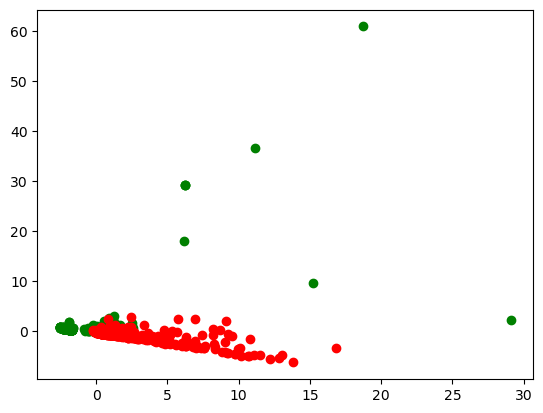

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=50)
pca_train_df = pca.fit_transform(train_df)

print("Transformed dataset shape:", pca_train_df.shape)
temp_df = pd.DataFrame(pca_train_df)
temp_df['label']=train_labels_df['label']
plt.scatter(temp_df[temp_df.label==1].iloc[:,0],temp_df[temp_df.label==1].iloc[:,1], c="green")
plt.scatter(temp_df[temp_df.label==-1].iloc[:,0],temp_df[temp_df.label==-1].iloc[:,1], c="red")
plt.show()




In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_test_df = pca.fit_transform(test_df)

print("Transformed dataset shape:", pca_test_df.shape)

Transformed dataset shape: (350, 50)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Output layer with 2 classes: active and inactive
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
input_size = num_cols
model = NeuralNetwork(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
train_label_tensor = torch.tensor((train_labels_df['label'].values + 1) // 2, dtype=torch.long)

num_epochs = 20
batch_size = 64
total_samples = train_tensor.shape[0]
total_batches = total_samples // batch_size
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(total_batches):
        start = i * batch_size
        end = start + batch_size
        inputs = train_tensor[start:end]
        labels = train_label_tensor[start:end]

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / total_batches
    loss_values.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/total_batches}")

test_tensor = torch.tensor(test_df.values, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    test_outputs = model(test_tensor)


Epoch 1/20, Loss: 0.5418297391046177
Epoch 2/20, Loss: 0.29187296534126456
Epoch 3/20, Loss: 0.10890621163310822
Epoch 4/20, Loss: 0.018272852687831884
Epoch 5/20, Loss: 0.004423753534369594
Epoch 6/20, Loss: 0.002003431414447153
Epoch 7/20, Loss: 0.0012059516963993453
Epoch 8/20, Loss: 0.0008191541998133868
Epoch 9/20, Loss: 0.0005921201521811203
Epoch 10/20, Loss: 0.0004449269518690099
Epoch 11/20, Loss: 0.00034392895726010795
Epoch 12/20, Loss: 0.0002717457508961988
Epoch 13/20, Loss: 0.0002185687581831272
Epoch 14/20, Loss: 0.0001786009579518577
Epoch 15/20, Loss: 0.00014792460652560376
Epoch 16/20, Loss: 0.00012405494519705164
Epoch 17/20, Loss: 0.00010519492719719314
Epoch 18/20, Loss: 9.015207483158024e-05
Epoch 19/20, Loss: 7.80002859425043e-05
Epoch 20/20, Loss: 6.807098568308653e-05


In [11]:
test_label_tensor = torch.tensor((test_labels_df['label'].values + 1) // 2, dtype=torch.long)

_, predicted_labels = torch.max(test_outputs, dim=1)
correct_predictions = (predicted_labels == test_label_tensor).sum().item()
total_predictions = test_label_tensor.size(0)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 94.29%


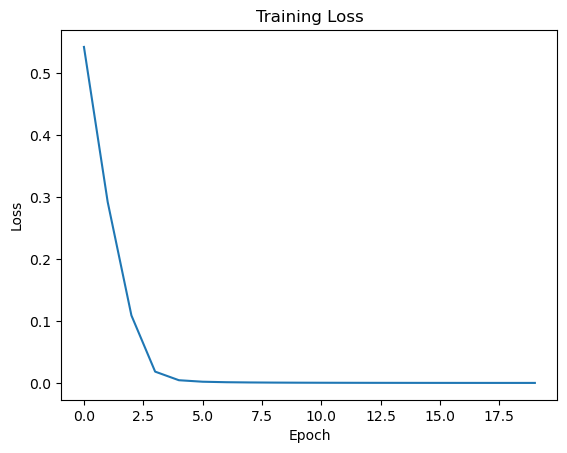

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_label_tensor = torch.tensor((test_labels_df['label'].values + 1) // 2, dtype=torch.long)
_, predicted_labels = torch.max(test_outputs, dim=1)

predicted_labels = predicted_labels.numpy()
test_labels = test_label_tensor.numpy()
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
print("Performance Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Performance Metrics:
Accuracy: 94.29%
Precision: 0.79
Recall: 0.56
F1-Score: 0.66


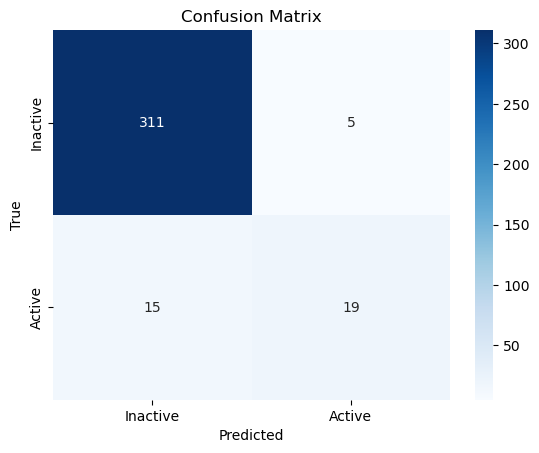

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predicted_labels)

fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

class_labels = ['Inactive', 'Active']
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()
